<a href="https://www.kaggle.com/code/maorsagi/malware-fraud-detection-2019?scriptVersionId=109723113" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install git+https://github.com/goolig/dsClass.git

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-b8v4vnhk
  Running command git clone -q https://github.com/goolig/dsClass.git /tmp/pip-req-build-b8v4vnhk
     |████████████████████████████████| 286kB 281kB/s 
  Created wheel for dsClass: filename=dsClass-1.0.27-cp36-none-any.whl size=16372735 sha256=15867f9f08c03d0e000092382fb2abf55d1033496ba2d73bee7cbf51f41fa549
  Stored in directory: /tmp/pip-ephem-wheel-cache-eixu59ij/wheels/c7/a9/03/023d8da4b4e004497715eeb1ea9b5d914ad425036bb4bc10b8
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp36-none-any.whl size=24566 sha256=06eea642a46b1e14d8f16e0803439a7ab220b7e2a52d03486e8c8f44f6313e65
  Stored in directory: /root/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built dsClass pydotplus


In [2]:
from sklearn.metrics import roc_curve, auc # model performance metrics
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dsClass.path_helper import *


There is 1 csv file in the current version of the dataset:


In [3]:
#print(os.listdir('../input'))

### Let's check 1st file: ../input/frd_sample.csv

In [4]:
data_path = get_file_path('frd_sample.csv')
df = pd.read_csv(data_path, delimiter=',')
df.dataframeName = 'frd_sample.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df_Q2=df

There are 3300 rows and 12 columns


Let's take a quick look at what the data looks like:

In [5]:
df.head(5)

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD
0,20160801 00:01,1,MOBILE-APP,Y,user260,86.132.25.214,ISP7,USA,payee48,CHN,2,G
1,20160801 00:05,2,WEB,N,user48,113.136.87.62,ISP8,GBR,payee2,YEM,20,G
2,20160801 00:07,3,MOBILE-APP,N,user181,94.97.9.208,ISP16,CHN,payee79,RUS,10,G
3,20160801 00:08,4,WEB,N,user242,170.245.72.244,ISP12,USA,payee33,RUS,20,G
4,20160801 00:08,5,MOBILE-BROWSER,N,user281,124.83.40.103,ISP29,CHN,payee5,CHN,90000,G


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 12 columns):
EVENT_TIME          3300 non-null object
EVENT_ID            3300 non-null int64
CHANNEL             3300 non-null object
CHALLENGE_RESULT    3300 non-null object
USER_ID             3300 non-null object
IP_ADDRESS          3300 non-null object
ISP                 3300 non-null object
USER_COUNTRY        3300 non-null object
PAYEE_ID            3300 non-null object
PAYEE_COUNTRY       3300 non-null object
AMOUNT              3300 non-null int64
IS_FRAUD            3300 non-null object
dtypes: int64(2), object(10)
memory usage: 309.5+ KB


Let's do some preprocessing:

In [7]:
# step1 - encode target variable

d = {"F":1, "G":0}
df["IS_FRAUD"].replace(d, inplace=True)

df.head()

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD
0,20160801 00:01,1,MOBILE-APP,Y,user260,86.132.25.214,ISP7,USA,payee48,CHN,2,0
1,20160801 00:05,2,WEB,N,user48,113.136.87.62,ISP8,GBR,payee2,YEM,20,0
2,20160801 00:07,3,MOBILE-APP,N,user181,94.97.9.208,ISP16,CHN,payee79,RUS,10,0
3,20160801 00:08,4,WEB,N,user242,170.245.72.244,ISP12,USA,payee33,RUS,20,0
4,20160801 00:08,5,MOBILE-BROWSER,N,user281,124.83.40.103,ISP29,CHN,payee5,CHN,90000,0


In [8]:
# now lets see how bayes works on a simple example of USER_COUNTRY column

df_exp = df[["EVENT_ID", "USER_COUNTRY","IS_FRAUD"]]

df_exp.head()

,EVENT_ID,USER_COUNTRY,IS_FRAUD
0,1,USA,0
1,2,GBR,0
2,3,CHN,0
3,4,USA,0
4,5,CHN,0


In [9]:
df_exp_train = df_exp.query("EVENT_ID <= 2200")
df_exp_train.tail()

,EVENT_ID,USER_COUNTRY,IS_FRAUD
2195,2196,ITA,0
2196,2197,GBR,0
2197,2198,USA,0
2198,2199,USA,0
2199,2200,NCL,1


In [10]:
df_exp_test  = df_exp.query("EVENT_ID  > 2200")
df_exp_test.tail()

,EVENT_ID,USER_COUNTRY,IS_FRAUD
3295,3296,ITA,0
3296,3297,DEU,0
3297,3298,USA,0
3298,3299,USA,0
3299,3300,CHN,1


In [11]:
tot_frd = df_exp_train.loc[(df_exp_train.IS_FRAUD == 1)].shape[0] # total fraud
tot_gen = df_exp_train.shape[0] - tot_frd

print([tot_frd,tot_gen])

[200, 2000]


In [12]:
countries = df["USER_COUNTRY"].unique()
print(countries)

['USA' 'GBR' 'CHN' 'ISL' 'ITA' 'DEU' 'MAC' 'NIC' 'NGA' 'MNP' 'NOR' 'PLW'
 'PNG' 'POL' 'COL' 'NLD' 'ARG' 'NCL' 'NZL' 'NER' 'PRK' 'OMN' 'PAN' 'PER'
 'PHL' 'PCN' 'PAK' 'PSE' 'PRY' 'NIU' 'ITL']


In [13]:
# for each country we calculate likelihood of a transaction being fraudulent
# בהנתן מדינה מסויימת כמה זיופים יש בטריינינג סט


p_f_ctry = {}

for country in countries:
    df_ctry = df_exp_train.loc[(df_exp_train.USER_COUNTRY == country)]
    df_ctry_frd = df_ctry.loc[(df_ctry.IS_FRAUD == 1)]
    
    ctry_frd = df_ctry_frd.shape[0]
    ctry_gen = df_ctry.shape[0] - ctry_frd
    
    if ctry_gen == 0: #inside the training set, there is no record (and we will meet this country on testing set).
                        #we have to set likelihood to fraud, 0 is special value.
        p_f_ctry[country] = 0
    else:
        p_f_ctry[country] =  (ctry_frd/tot_frd) / (ctry_gen/tot_gen) 
    
print(p_f_ctry)

{'USA': 0.9523809523809523, 'GBR': 0.8955223880597014, 'CHN': 0.9829059829059829, 'ISL': 0.8333333333333334, 'ITA': 0.7575757575757576, 'DEU': 0.857142857142857, 'MAC': 0.923076923076923, 'NIC': 1.0526315789473684, 'NGA': 0.7017543859649122, 'MNP': 1.5789473684210527, 'NOR': 0.6382978723404255, 'PLW': 0.4878048780487805, 'PNG': 0.625, 'POL': 1.3953488372093024, 'COL': 1.153846153846154, 'NLD': 1.2612612612612613, 'ARG': 1.076923076923077, 'NCL': 1.1864406779661019, 'NZL': 0.8163265306122449, 'NER': 1.0256410256410258, 'PRK': 1.3636363636363638, 'OMN': 1.1904761904761905, 'PAN': 0.9523809523809523, 'PER': 1.5384615384615383, 'PHL': 1.0869565217391306, 'PCN': 0.47619047619047616, 'PAK': 1.3157894736842106, 'PSE': 1.2195121951219512, 'PRY': 1.3636363636363638, 'NIU': 0.9523809523809523, 'ITL': 0}


In [14]:
y_score = df_exp_test["USER_COUNTRY"]
y_score.replace(p_f_ctry, inplace=True)

y_score.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


2200    0.952381
2201    0.895522
2202    0.982906
2203    1.261261
2204    0.952381
Name: USER_COUNTRY, dtype: float64

In [15]:
y_test = df_exp_test["IS_FRAUD"]

y_test.head()


2200    0
2201    0
2202    0
2203    0
2204    0
Name: IS_FRAUD, dtype: int64

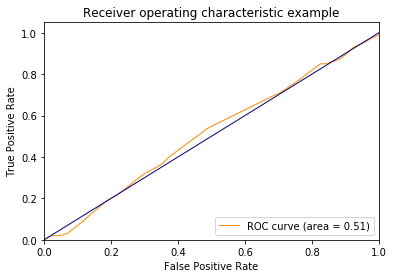

In [16]:
# Compute ROC curve and ROC area
    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Self-Assessment A**
* Calculate a similar ROC/AUC performance metric on training data and compare it with the above. Would you expect the AUC results to be better/worse than for the testing set?

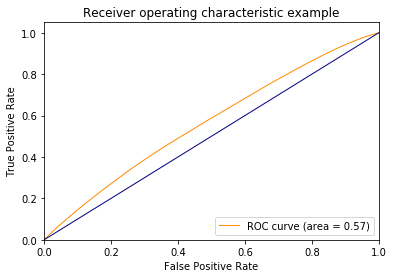

In [17]:
# add code here
# Its going to be better, we get 0.57>0.52 comparing to the last ROC, the best area is 1

y_score = df_exp_train["USER_COUNTRY"]
y_score.replace(p_f_ctry, inplace=True)

y_train = df_exp_train["IS_FRAUD"]

fpr, tpr, _ = roc_curve(y_train, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Let's generate more features:

# 1. USER_COUNTRY/PAYEE_COUNTRY

df_temp = df.copy()

df_temp["USER_CTRY_PAYEE_CTRY"] = df_temp["USER_COUNTRY"].str.cat(df_temp["PAYEE_COUNTRY"], sep=';')

df_temp.head()

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD,USER_CTRY_PAYEE_CTRY
0,20160801 00:01,1,MOBILE-APP,Y,user260,86.132.25.214,ISP7,USA,payee48,CHN,2,0,USA;CHN
1,20160801 00:05,2,WEB,N,user48,113.136.87.62,ISP8,GBR,payee2,YEM,20,0,GBR;YEM
2,20160801 00:07,3,MOBILE-APP,N,user181,94.97.9.208,ISP16,CHN,payee79,RUS,10,0,CHN;RUS
3,20160801 00:08,4,WEB,N,user242,170.245.72.244,ISP12,USA,payee33,RUS,20,0,USA;RUS
4,20160801 00:08,5,MOBILE-BROWSER,N,user281,124.83.40.103,ISP29,CHN,payee5,CHN,90000,0,CHN;CHN


In [19]:
# 2. USER_HITS

users = df_temp["USER_ID"].unique()

evt_val_dict = {}
for user in users:
    df_loop = df_temp.loc[(df_temp.USER_ID == user)]
    
    hits = 1
    for index, row in df_loop.iterrows():
        evt_val_dict[row['EVENT_ID']] = hits
        hits = hits + 1
    
df_temp["USER_HITS"] = df_temp["EVENT_ID"].apply(evt_val_dict.get) # הפעלת הפונקציה על העמודה שנתנו
df_temp.tail()

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD,USER_CTRY_PAYEE_CTRY,USER_HITS
3295,20160806 23:53,3296,MOBILE-BROWSER,Y,user666,97.11.124.174,ISP12,ITA,payee76,RUS,600,0,ITA;RUS,5
3296,20160806 23:56,3297,WEB,Y,user710,112.252.209.145,ISP23,DEU,payee22,RUS,70000,0,DEU;RUS,6
3297,20160806 23:56,3298,MOBILE-BROWSER,Y,user727,3.192.111.10,ISP5,USA,payee7,USA,7,0,USA;USA,6
3298,20160806 23:57,3299,MOBILE-BROWSER,Y,user647,111.71.144.92,ISP24,USA,payee2,CHN,400,0,USA;CHN,6
3299,20160806 23:59,3300,WEB,Y,user21,180.244.208.180,ISP17,CHN,payee23,CHN,100,1,CHN;CHN,9


In [20]:
print(df_temp.query("USER_ID == 'user21'"))

          EVENT_TIME  EVENT_ID         CHANNEL CHALLENGE_RESULT USER_ID  \
2222  20160805 00:52      2223      MOBILE-APP                Y  user21   
2280  20160805 03:25      2281      MOBILE-APP                N  user21   
2396  20160805 08:43      2397      MOBILE-APP                Y  user21   
2434  20160805 10:49      2435             WEB                Y  user21   
2444  20160805 11:19      2445  MOBILE-BROWSER                N  user21   
2643  20160805 19:32      2644             WEB                N  user21   
2970  20160806 10:29      2971      MOBILE-APP                N  user21   
3273  20160806 22:49      3274  MOBILE-BROWSER                Y  user21   
3299  20160806 23:59      3300             WEB                Y  user21   

           IP_ADDRESS    ISP USER_COUNTRY PAYEE_ID PAYEE_COUNTRY  AMOUNT  \
2222   145.147.91.244   ISP5          USA   payee4           TUN      30   
2280      53.44.88.55  ISP30          NLD  payee17           VEN    6000   
2396    23.184.243.53

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Self-Assessment B**
* Using both techniques shown above calculate USER_PAYEE_HITS - number of hits from USER_ID/PAYEE_ID combination
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
# add code here
#יצרנו פיצ'ר חדש - אנחנו מוסיפים תוך כדיי

df_temp["USER_PAYEE"] = df_temp["USER_ID"].str.cat(df_temp["PAYEE_ID"], sep=';')

df_temp.head()

# 3. USER_PAYEE_HITS

user_payee_combinations = df_temp["USER_PAYEE"].unique()

evt_val_dict = {}
for user_payee_comb in user_payee_combinations:
    df_loop = df_temp.loc[(df_temp.USER_PAYEE == user_payee_comb)]
    
    hits = 1
    for index, row in df_loop.iterrows():
        evt_val_dict[row['EVENT_ID']] = hits
        hits = hits + 1
    
df_temp["USER_PAYEE_HITS"] = df_temp["EVENT_ID"].apply(evt_val_dict.get)
df_temp.tail()

,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD,USER_CTRY_PAYEE_CTRY,USER_HITS,USER_PAYEE,USER_PAYEE_HITS
3295,20160806 23:53,3296,MOBILE-BROWSER,Y,user666,97.11.124.174,ISP12,ITA,payee76,RUS,600,0,ITA;RUS,5,user666;payee76,1
3296,20160806 23:56,3297,WEB,Y,user710,112.252.209.145,ISP23,DEU,payee22,RUS,70000,0,DEU;RUS,6,user710;payee22,1
3297,20160806 23:56,3298,MOBILE-BROWSER,Y,user727,3.192.111.10,ISP5,USA,payee7,USA,7,0,USA;USA,6,user727;payee7,1
3298,20160806 23:57,3299,MOBILE-BROWSER,Y,user647,111.71.144.92,ISP24,USA,payee2,CHN,400,0,USA;CHN,6,user647;payee2,3
3299,20160806 23:59,3300,WEB,Y,user21,180.244.208.180,ISP17,CHN,payee23,CHN,100,1,CHN;CHN,9,user21;payee23,1


In [22]:
print(df_temp.query("USER_PAYEE== 'user647;payee2'"))

          EVENT_TIME  EVENT_ID         CHANNEL CHALLENGE_RESULT  USER_ID  \
3098  20160806 15:50      3099  MOBILE-BROWSER                Y  user647   
3169  20160806 18:22      3170      MOBILE-APP                N  user647   
3298  20160806 23:57      3299  MOBILE-BROWSER                Y  user647   

           IP_ADDRESS    ISP USER_COUNTRY PAYEE_ID PAYEE_COUNTRY  AMOUNT  \
3098    237.155.198.1  ISP21          OMN   payee2           TWN      40   
3169  183.193.152.218  ISP12          PNG   payee2           RUS     200   
3298    111.71.144.92  ISP24          USA   payee2           CHN     400   

      IS_FRAUD USER_CTRY_PAYEE_CTRY  USER_HITS      USER_PAYEE  \
3098         0              OMN;TWN          2  user647;payee2   
3169         0              PNG;RUS          3  user647;payee2   
3298         0              USA;CHN          6  user647;payee2   

      USER_PAYEE_HITS  
3098                1  
3169                2  
3298                3  


In [23]:
features = ["CHANNEL","ISP","USER_COUNTRY","PAYEE_COUNTRY","USER_CTRY_PAYEE_CTRY","USER_HITS","USER_PAYEE_HITS","IS_FRAUD","EVENT_ID"]

df2 = df_temp[features]
df2.head()

,CHANNEL,ISP,USER_COUNTRY,PAYEE_COUNTRY,USER_CTRY_PAYEE_CTRY,USER_HITS,USER_PAYEE_HITS,IS_FRAUD,EVENT_ID
0,MOBILE-APP,ISP7,USA,CHN,USA;CHN,1,1,0,1
1,WEB,ISP8,GBR,YEM,GBR;YEM,1,1,0,2
2,MOBILE-APP,ISP16,CHN,RUS,CHN;RUS,1,1,0,3
3,WEB,ISP12,USA,RUS,USA;RUS,1,1,0,4
4,MOBILE-BROWSER,ISP29,CHN,CHN,CHN;CHN,1,1,0,5


In [24]:
df_exp_train = df2.query("EVENT_ID <= 2200")
df_exp_test  = df2.query("EVENT_ID  > 2200")

for feature in features:
    
    if feature == "IS_FRAUD" or feature == "EVENT_ID":
        continue
    
    
    unique_values = df2[feature].unique()
    d = {}
    
    for val in unique_values:
        df_feat = df_exp_train.loc[(df_exp_train[feature] == val)]
        df_feat_frd = df_feat.loc[(df_feat.IS_FRAUD == 1)]

        feat_frd = df_feat_frd.shape[0]
        feat_gen = df_feat.shape[0] - feat_frd
        
        feat_frd = feat_frd + 0.000001 #פותר את הבעיה הנומרית למקרה שאין fraud
        
        if feat_gen == 0:
            d[val] = 0
        else:
            d[val] = 1000*np.log ( (feat_frd/tot_frd) / (feat_gen/tot_gen) )
    
    df_exp_test[feature].replace(d, inplace=True)
    df_exp_train[feature].replace(d, inplace=True)

df_exp_test.tail()

,CHANNEL,ISP,USER_COUNTRY,PAYEE_COUNTRY,USER_CTRY_PAYEE_CTRY,USER_HITS,USER_PAYEE_HITS,IS_FRAUD,EVENT_ID
3295,7.490687,-470.003429,-277.631537,67.208800,-11512.925465,1318.086141,-59.917198,0,3296
3296,-12.048323,-139.761776,-154.150513,67.208800,-336.471987,2692.049892,-59.917198,0,3297
3297,7.490687,162.519054,-48.790123,-145.953841,-14648.419681,2692.049892,-59.917198,0,3298
3298,7.490687,64.538646,-48.790123,-26.907407,-14880.221295,2692.049892,2995.732774,0,3299
3299,-12.048323,0.000000,-17.241763,-26.907407,3688.879517,4605.170286,-59.917198,1,3300


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Self-Assessment C**

Note "-inf" values for some columns, why this is happening and how we can fix it?

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# add code here

df_exp_train = df2.query("EVENT_ID <= 2200")
df_exp_test  = df2.query("EVENT_ID  > 2200")

for feature in features:
    
    if feature == "IS_FRAUD" or feature == "EVENT_ID":
        continue
    
    
    unique_values = df2[feature].unique()
    d = {}
    
    for val in unique_values:
        df_feat = df_exp_train.loc[(df_exp_train[feature] == val)]
        df_feat_frd = df_feat.loc[(df_feat.IS_FRAUD == 1)]

        feat_frd = df_feat_frd.shape[0]
        feat_gen = df_feat.shape[0] - feat_frd
        
        feat_frd = feat_frd + 0.00001 # suggested fix
        
        if feat_gen == 0:
            d[val] = 0
        else:
            d[val] = 1000*np.log ( (feat_frd/tot_frd) / (feat_gen/tot_gen) )
    
    df_exp_test [feature].replace(d, inplace=True)
    df_exp_train[feature].replace(d, inplace=True)

df_exp_test.tail()

,CHANNEL,ISP,USER_COUNTRY,PAYEE_COUNTRY,USER_CTRY_PAYEE_CTRY,USER_HITS,USER_PAYEE_HITS,IS_FRAUD,EVENT_ID
3295,7.490821,-470.001629,-277.629737,67.209250,-9210.340372,1318.086405,-59.917149,0,3296
3296,-12.048187,-139.760276,-154.149013,67.209250,-336.469737,2692.050182,-59.917149,0,3297
3297,7.490821,162.520179,-48.789748,-145.953198,-12345.834588,2692.050182,-59.917149,0,3298
3298,7.490821,64.539771,-48.789748,-26.906998,-12577.636202,2692.050182,2995.737274,0,3299
3299,-12.048187,0.000000,-17.241372,-26.906998,3688.880079,4605.171186,-59.917149,1,3300


In [26]:
df_exp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 0 to 2199
Data columns (total 9 columns):
CHANNEL                 2200 non-null float64
ISP                     2200 non-null float64
USER_COUNTRY            2200 non-null object
PAYEE_COUNTRY           2200 non-null object
USER_CTRY_PAYEE_CTRY    2200 non-null object
USER_HITS               2200 non-null float64
USER_PAYEE_HITS         2200 non-null float64
IS_FRAUD                2200 non-null int64
EVENT_ID                2200 non-null int64
dtypes: float64(4), int64(2), object(3)
memory usage: 171.9+ KB


In [27]:
# now we aggregate the contribution of different features into a single fraud likelihood

df_exp_train["SCORE"] = 0.0
df_exp_test ["SCORE"] = 0.0

for feature in features:
    
    if feature == "IS_FRAUD" or feature == "EVENT_ID":
        continue
    
    df_exp_train["SCORE"] = df_exp_train["SCORE"] + df_exp_train[feature]
    df_exp_test ["SCORE"] = df_exp_test ["SCORE"] + df_exp_test [feature]
    
df_exp_test.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,CHANNEL,ISP,USER_COUNTRY,PAYEE_COUNTRY,USER_CTRY_PAYEE_CTRY,USER_HITS,USER_PAYEE_HITS,IS_FRAUD,EVENT_ID,SCORE
2200,4.487816,-1005.518532,-48.789748,-26.906998,-12577.636202,-2958.373154,-59.917149,0,2201,-16672.653967
2201,-12.048187,-500.772788,-110.347224,0.002000,0.002000,-2958.373154,-59.917149,0,2202,-3641.454501
2202,7.490821,-654.923468,-17.241372,105.362516,198.452939,-2958.373154,-59.917149,0,2203,-3379.148867
2203,-12.048187,192.373143,232.112936,-1147.397453,-832.904123,-2958.373154,-59.917149,0,2204,-4586.153987
2204,4.487816,-500.772788,-48.789748,-16.527635,-10596.634733,-2958.373154,-59.917149,0,2205,-14176.527391


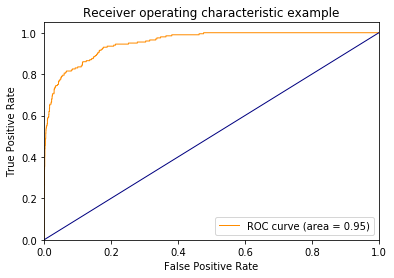

In [28]:
y = df_exp_train["IS_FRAUD"]
y_score = df_exp_train["SCORE"]

# Compute ROC curve and ROC area 
#suppose to be area = 0.90
    
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
**Self-Assessment D**
* Is NB classifier suggested above is a black-box or a white-box model. 
* Suggest and implement a method for feature importance calculation based on df_exp_train data. Plot the importance and discuss the results
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

{'USER_CTRY_PAYEE_CTRY': 0.42681818181817355, 'USER_HITS': 0.46999999999998937, 'ISP': 0.0713636363636366, 'USER_PAYEE_HITS': 0.010909090909090908, 'PAYEE_COUNTRY': 0.010909090909090908, 'USER_COUNTRY': 0.01}


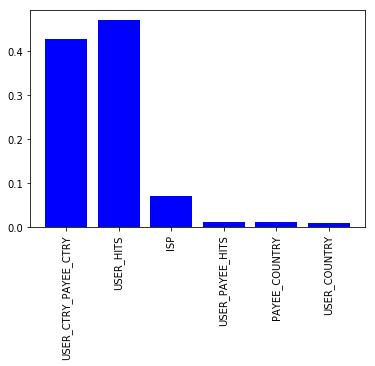

In [29]:
# add code here
# Calculate simple "winner takes it all" feature importance over training data

feat_importance = {}

df = df_exp_train

for index, row in df.iterrows():
    max_abs = 0.0
    max_feat = ""
    
    for feature in features:
        if feature == "IS_FRAUD" or feature == "EVENT_ID":
            continue
        if np.absolute(row[feature]) > max_abs:
            max_abs = np.abs(row[feature])
            max_feat = feature
    
    if max_feat in feat_importance:
        feat_importance[max_feat] = feat_importance[max_feat] + 1/df.shape[0]
    else:
        feat_importance[max_feat] = 1/df.shape[0]
        
print(feat_importance)

import matplotlib.pyplot as plt

plt.bar(list(feat_importance.keys()), feat_importance.values(), color='b')
plt.xticks(rotation=90)
plt.show()

Q1

הביטוי שהשתמשנו אכן משקף את הסבירויות.
נמיר את הביטוי הנתון לכמויות במקום הסתברויות:

(Pr(crty|tot_frd)/Pr(ctry|tot_gen)) * (Pr(tot_frd)/Pr(tot_gen)) > 1 => 
((ctry_frd/tot_frd) / (ctry_gen/tot_gen)) * ((tot_frd/total)/(tot_gen/total) = (ctry_frd / ctry_gen)

כעת נתבונן על הביטוי שהשתמשנו בתוכנית (נזניח הכפלה בלוג):

((ctry_frd/tot_frd) / (ctry_gen/tot_gen)) = ( ctry_frd / ctry_gen ) * **( tot_gen / tot_frd )**

השינוי בין הביטויים הינו הביטוי המודגש. נשים לב כי במקרה שלנו זהו מספר קבוע ולכן הנוסחה שהשתמשנו כן מייצגת את הסבירויות הנדרשות ולכן ניתן להזניח הכפלה זו.

Q2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

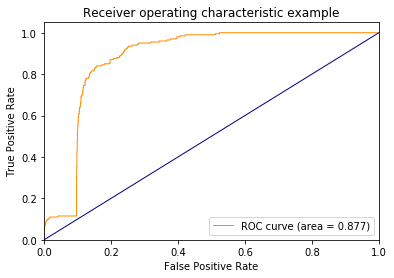

In [30]:
df_new = df_exp_train

amount_train = df_Q2.query("EVENT_ID <= 2200")["AMOUNT"]

df_new["AMOUNT_CATAGORY_TMP"] = pd.cut(np.array(amount_train),2)
df_new["AMOUNT_CATAGORY"] = 0.0

for index, row in df_new.iterrows():
    df_new["AMOUNT_CATAGORY"][index] = df_new["AMOUNT_CATAGORY_TMP"][index].right

df_new = df_new.drop(["AMOUNT_CATAGORY_TMP"],axis=1)

df_new["SCORE_WITH_AMOUNT"] = 0.0

features = ["CHANNEL","ISP","USER_COUNTRY","PAYEE_COUNTRY","USER_CTRY_PAYEE_CTRY","USER_HITS","USER_PAYEE_HITS","IS_FRAUD","EVENT_ID","AMOUNT_CATAGORY"]

for feature in features:
    
    if feature == "IS_FRAUD" or feature == "EVENT_ID":
        continue
    
    df_new["SCORE_WITH_AMOUNT"] = df_new["SCORE_WITH_AMOUNT"] + df_new[feature]

y = df_new["IS_FRAUD"]
y_score = df_new["SCORE_WITH_AMOUNT"]

# Compute ROC curve and ROC area 
#suppose to be area = 0.90
    
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



Q3

In [31]:

user_channel = {}
user_payees = {}

df_Q2["USER_CHANNEL_VELO"]=0
df_Q2["USER_PAYEE_VELO"]=0

for index, row in df_Q2.iterrows():

    if row["USER_ID"] in user_channel  and row["USER_ID"] in user_payees:
        if not (row["CHANNEL"] in user_channel[row["USER_ID"]]):
            user_channel[row["USER_ID"]].append(row["CHANNEL"])
        if not (row["PAYEE_ID"] in user_channel[row["USER_ID"]]):
            user_payees[row["USER_ID"]].append(row["PAYEE_ID"])
            
    else:
        user_channel[row["USER_ID"]]= [row["CHANNEL"]]
        user_payees[row["USER_ID"]]= [row["PAYEE_ID"]]
        
    
    df_Q2["USER_CHANNEL_VELO"][index]= len(user_channel[row["USER_ID"]])
    df_Q2["USER_PAYEE_VELO"][index]= len(user_payees[row["USER_ID"]])

df_Q2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,EVENT_TIME,EVENT_ID,CHANNEL,CHALLENGE_RESULT,USER_ID,IP_ADDRESS,ISP,USER_COUNTRY,PAYEE_ID,PAYEE_COUNTRY,AMOUNT,IS_FRAUD,USER_CHANNEL_VELO,USER_PAYEE_VELO
0,20160801 00:01,1,MOBILE-APP,Y,user260,86.132.25.214,ISP7,USA,payee48,CHN,2,0,1,1
1,20160801 00:05,2,WEB,N,user48,113.136.87.62,ISP8,GBR,payee2,YEM,20,0,1,1
2,20160801 00:07,3,MOBILE-APP,N,user181,94.97.9.208,ISP16,CHN,payee79,RUS,10,0,1,1
3,20160801 00:08,4,WEB,N,user242,170.245.72.244,ISP12,USA,payee33,RUS,20,0,1,1
4,20160801 00:08,5,MOBILE-BROWSER,N,user281,124.83.40.103,ISP29,CHN,payee5,CHN,90000,0,1,1


Q4

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


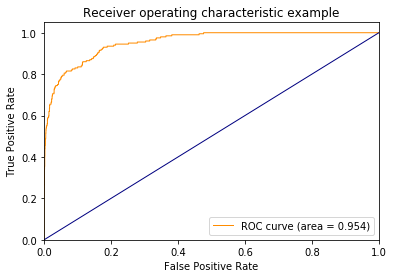

In [32]:

isp_ctry = {}


df_new["ISP_COUNTRY"]=0

for index, row in df_new.iterrows():

    if row["ISP"] in isp_ctry :
        isp_ctry[row["ISP"]]= np.unique(isp_ctry[row["ISP"]] + [row["USER_COUNTRY"]])
    
    else:
        isp_ctry[row["ISP"]]= [row["USER_COUNTRY"]]


    df_new["ISP_COUNTRY"][index]= len(isp_ctry[row["ISP"]])

df_new["SCORE_ISP_CTRY"] = 0
features = ["CHANNEL","ISP","USER_COUNTRY","PAYEE_COUNTRY","USER_CTRY_PAYEE_CTRY","USER_HITS","USER_PAYEE_HITS","IS_FRAUD","EVENT_ID","ISP_COUNTRY"]

for feature in features:
    
    if feature == "IS_FRAUD" or feature == "EVENT_ID":
        continue
    
    df_new["SCORE_ISP_CTRY"] = df_new["SCORE_ISP_CTRY"] + df_new[feature]

y = df_new["IS_FRAUD"]
y_score = df_new["SCORE_ISP_CTRY"]

# Compute ROC curve and ROC area 
#suppose to be area = 0.90
    
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
